In [1]:
import numpy as np
import numpy.linalg as la
from cosmoTransitions import generic_potential as gp
from matplotlib import pyplot as plt

In [175]:
mZEW = 91.1876
GF = 1.1663787e-05
v = (2**0.5 * GF)**(-0.5)/np.sqrt(2)
v2 = v**2
mhpole = 125.13
g1 = 0.3573944734603928
g2 = 0.6510161183564389
yt = 0.9777726923522626

In [133]:
v

174.10358473791823

In [55]:
from finiteT import Jb_spline as Jb
from finiteT import Jf_spline as Jf
from cosmoTransitions.finiteT import Jb_exact2 as Jbe
from cosmoTransitions.finiteT import Jf_exact2 as Jfe

/Users/quarkquartet/opt/anaconda3/lib/python3.9/site-packages/cosmoTransitions/finiteT.py:88: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integrate.quad(f1, 0, abs(theta)**.5)[0]
/Users/quarkquartet/opt/anaconda3/lib/python3.9/site-packages/cosmoTransitions/finiteT.py:88: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  integrate.quad(f1, 0, abs(theta)**.5)[0]


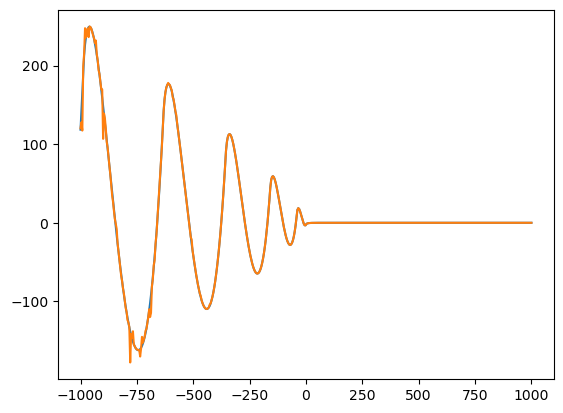

In [64]:
x_list = np.linspace(-1000,1000, 500)
Jblist = Jb(x_list)
Jbelist = Jbe(x_list)
plt.plot(x_list,Jblist)
plt.plot(x_list,Jbelist)

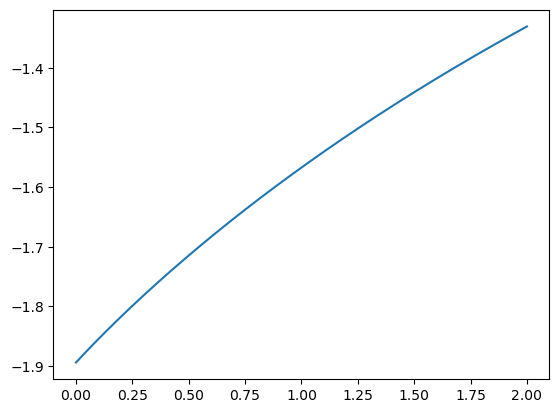

In [230]:
x_list = np.linspace(0,2,300)
y_list = Jf(x_list)
plt.plot(x_list,y_list)

In [219]:
class model_ALP(gp.generic_potential):
    """
    Class of CosmoTransitions. Input parameters are the 1-loop renormalized
    parameters (but not the directly-observed quantites such as mixing angle or mass).

    Parameters include:
    lh: Higgs quartic coupling.
    A: Higgs-ALP coupling.
    muHsq: Higgs mass term squared.
    muSsq: ALP mass term squared.
    f: scale parameter for the ALP, i.e. the "decay constant" of the axion. Could
    be understood as the UV-completion scale.
    beta: phase difference between the ALP mass term and the Higgs-ALP interaction term.

    Effective potential of the model, and some defined functions for computation.
    """

    def init(self, lh, A, muHsq, muSsq, f, beta):
        self.Ndim = 2
        self.g1 = g1
        self.g2 = g2
        self.yt = yt
        self.lh = lh
        self.A = A
        self.muHsq = muHsq
        self.muSsq = muSsq
        self.f = f
        self.beta = beta
        self.Tmax = 200
        self.renormScaleSq = mZEW**2

    def V0(self, X):
        """Tree-level potential."""

        # Define field variable quantities
        X = np.asanyarray(X)
        assert X.shape[-1] == 2

        h = X[..., 0]
        S = X[..., 1]

        # tree-level potential
        y_h = -0.5 * self.muHsq * h**2 + 0.25 * self.lh * h**4
        y_S = -self.f**2 * self.muSsq * (np.cos(S / self.f) - 1)
        y_hS = (
            -0.5 * self.A * self.f * (h**2 - 2 * v2) * np.sin(self.beta + S / self.f)
        )
        tot = y_h + y_S + y_hS

        return tot

    def boson_massSq(self, X, T):
        """
        Method of CosmoTransitions. Returns bosons mass square, dof and constants. The scalar masses are the eigenvalues of the full physical scalar matrix, plus the Nambu-Goldstone bosons.
        """

        X = np.array(X)
        T = np.asanyarray(T, dtype=float)
        T2 = T * T
        assert X.shape[-1] == 2
        h = X[..., 0]
        S = X[..., 1]

        mgs = (
            self.lh * h**2
            - self.muHsq
            - self.A * self.f * np.sin(S / self.f + self.beta)
        ) + (
            3 * self.g2**2 / 16 + self.g1**2 / 16 + 0.5 * self.lh + 0.25 * self.yt**2
        ) * T2

        # Scalar mass matrix ((a,c),(c,b))
        aterm = (
            3 * self.lh * h**2
            - self.muHsq
            - self.A * self.f * np.sin(S / self.f + self.beta)
        ) + (
            3 * self.g2**2 / 16 + self.g1**2 / 16 + 0.5 * self.lh + 0.25 * self.yt**2
        ) * T2

        cterm = -self.A * h * np.cos(S / self.f + self.beta)

        bterm = 0.5 * (
            self.A * (h**2 - 2 * v2) * np.sin(self.beta + S / self.f)
        ) / self.f + self.muSsq * np.cos(S / self.f)

        # Scalar eigenvalues
        mhsq = 0.5 * (aterm + bterm + np.sqrt((aterm - bterm) ** 2 + 4 * cterm**2))
        mSsq = 0.5 * (aterm + bterm - np.sqrt((aterm - bterm) ** 2 + 4 * cterm**2))

        mW = 0.25 * self.g2**2 * h**2
        mWL = mW + 11 * self.g2**2 * T2 / 6
        mZ = 0.25 * (self.g2**2 + self.g1**2) * h**2

        AZsq = np.sqrt(
            (self.g2**2 + self.g1**2) ** 2 * (3 * h**2 + 22 * T2) ** 2
            - 176 * self.g2**2 * self.g1**2 * T2 * (3 * h**2 + 11 * T2)
        )

        mZL = ((self.g2**2 + self.g1**2) * (3 * h**2 + 22 * T2) + AZsq) / 24
        mAL = ((self.g2**2 + self.g1**2) * (3 * h**2 + 22 * T2) - AZsq) / 24

        M = np.array([mSsq, mhsq, mgs, mW, mWL, mZ, mZL, mAL])
        M = np.rollaxis(M, 0, len(M.shape))

        dof = np.array([1, 1, 3, 4, 2, 2, 1, 1])
        c = np.array([1.5, 1.5, 1.5, 0.5, 1.5, 0.5, 1.5, 1.5])

        return M.real + 1e-16, dof, c

    def fermion_massSq(self, X):
        """
        Method of CosmoTransitions. Fermion mass square. Only top quark is included.
        """

        X = np.array(X)
        h = X[..., 0]

        mt = 0.5 * self.yt**2 * h**2
        Mf = np.array([mt])
        Mf = np.rollaxis(Mf, 0, len(Mf.shape))

        doff = np.array([12.0])

        return Mf, doff

    def V1(self, bosons, fermions, scale=mZEW):
        """
        Method of CosmoTransitions. Overwritten.

        The 1-loop CW correction at the zero-temperature in the
        MS-bar renormalization scheme.
        """

        scale2 = scale**2
        m2, n, c = bosons
        y = np.sum(n * m2 * m2 * (np.log(m2 / scale2 + 1e-100 + 0j) - c), axis=-1)
        m2, n = fermions
        c = 1.5
        y -= np.sum(n * m2 * m2 * (np.log(m2 / scale2 + 1e-100 + 0j) - c), axis=-1)
        return y.real / (64 * np.pi * np.pi)

    def V0T(self, X):
        """
        1-loop corrected effective potential at T=0.
        Not an intrinsic method of CosmoTransitions.
        """
        X = np.asanyarray(X, dtype=float)

        bosons = self.boson_massSq(X, 0)
        fermions = self.fermion_massSq(X)

        y = self.V0(X)
        y += self.V1(bosons, fermions)

        return y

    def V1T(self, bosons, fermions, T, include_radiation=True):
        """
        Method of CosmoTransitions. Should be overwritten.
        The 1-loop finite-temperature correction term.

        `Jf` and `Jb` are modified functions.

        TODO: understand this again, write note, and implement it.
        """

        T2 = (T * T) + 1e-100
        T4 = T2*T2

        m2, nb, _ = bosons
        y = np.sum(nb * Jb(m2 / T2), axis=-1)
        m2, nf = fermions
        y += np.sum(nf * Jf(m2 / T2), axis=-1)

        return y * T4 / (2 * np.pi * np.pi)

    def Vtot(self, X, T, include_radiation=True):
        """
        Method of CosmoTransitions.
        The total finite temperature effective potential.
        """

        T = np.asanyarray(T, dtype=float)
        X = np.asanyarray(X, dtype=float)
        assert X.shape[-1] == 2

        bosons = self.boson_massSq(X, T)
        fermions = self.fermion_massSq(X)
        Vtot = self.V0(X)
        Vtot += self.V1(bosons, fermions)
        Vtot += self.V1T(bosons, fermions, T, include_radiation)

        return Vtot

    def approxZeroTMin(self):
        # There are generically two minima at zero temperature in this model,
        # and we want to include both of them.
        return [np.array([v, 0]), np.array([-v, 0])]

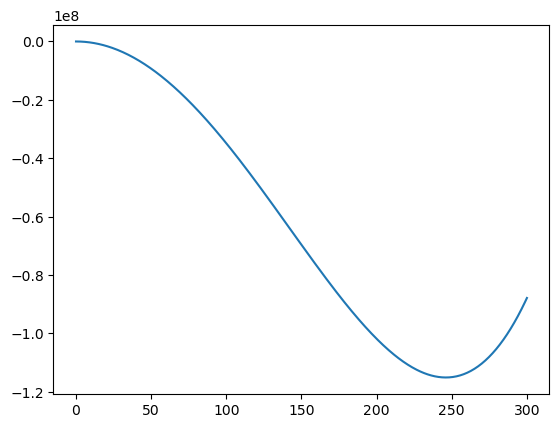

In [190]:
model = model_ALP(0.125559, 11.1902, -338194, 21.8353**2, 1e5, np.pi/10)
h_list = np.linspace(0,300,500)
y_list_tree = [model.V0([i,0])-model.V0([1e-16,0]) for i in h_list]
plt.plot(h_list, y_list_tree)
# test tree-level

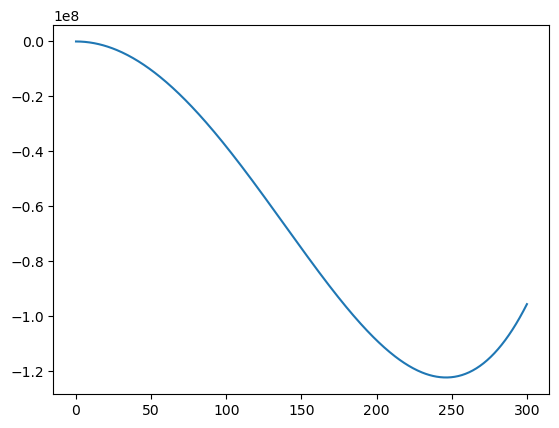

In [191]:
model = model_ALP(0.14707, 11.264, -339459, 480.134, 1e5, np.pi/10)
h_list = np.linspace(0,300,500)
y_list = [model.V0T([i,0])-model.V0T([0,0]) for i in h_list]
plt.plot(h_list, y_list)
# test 1-loop level

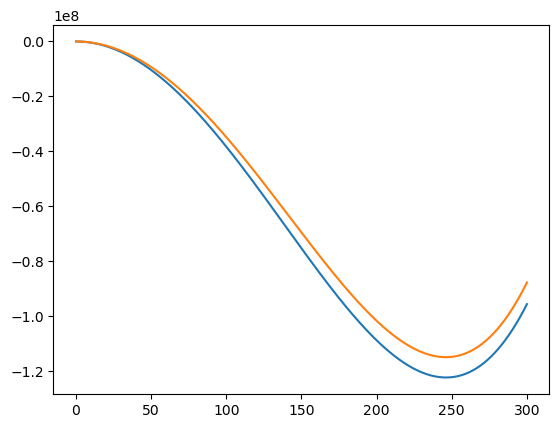

In [192]:
plt.plot(h_list, y_list)
plt.plot(h_list, y_list_tree)

In [220]:
model = model_ALP(0.14749514745168907, 10.61953003921521, -319517.7321162796, 428.1718668797098, 1e5, np.pi/10)

In [232]:
model.calcTcTrans()

Tracing phase starting at x = [-244.72044492   -9.24339958] ; t = 0.0
Tracing minimum up
traceMinimum t0 = 0
...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[{'Tcrit': 65.46275693685845,
  'high_vev': array([-3.00608589e-03, -7.02850320e+02]),
  'high_phase': 1,
  'low_vev': array([  60.89386194, -660.62962636]),
  'low_phase': 2,
  'trantype': 1,
  'Delta_rho': 4990415.084939957},
 {'Tcrit': 65.46275693667161,
  'high_vev': array([-3.00608589e-03, -7.02850320e+02]),
  'high_phase': 1,
  'low_vev': array([ -60.89600017, -660.62633608]),
  'low_phase': 0,
  'trantype': 1,
  'Delta_rho': 4990754.872997284}]